# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 池品叡, B094020030.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [166]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #
    #######################################################################
    elif rot == 1:
        return transforms.functional.rotate(img, 90)
    elif rot == 2:
        return transforms.functional.rotate(img, 180)
    elif rot == 3:
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [167]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


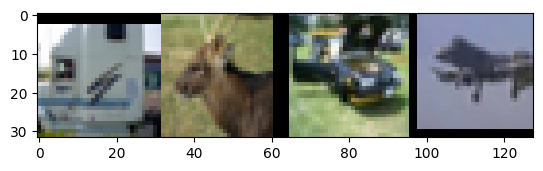

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  truck deer  car   plane


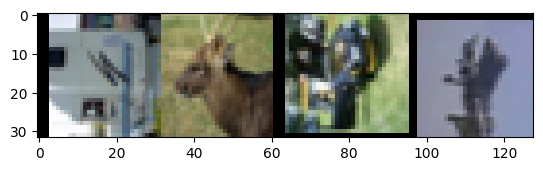

Rotation labels:  90    0     90    270  


In [168]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [230]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # Get the prediction result.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [231]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [232]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [233]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [236]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [235]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            inputs = torch.zeros(len(imgs))
            labels = torch.zeros(len(cls_label))
            if task == 'rotation':
              inputs = imgs_rotated.to(device)
              labels = rotation_label.to(device)

            elif task == 'classification':
              inputs = imgs.to(device)
              labels = cls_label.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        run_test(net=net, testloader=testloader, criterion= criterion, task = task)
        net.eval()
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################

    print('Finished Training')

## Training Loop

In [228]:
net = torch.load('B094020030_rot_mdl.pt')

In [237]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.001, task='rotation')
################################
#     TODO: Save the model     #
################################
#torch.save(net.state_dict(), 'TRAINING.pt')
################################
#      End of your code        #
################################

[1,   100] loss: 1.274 acc: 43.03 time: 6.48
[1,   200] loss: 1.128 acc: 51.05 time: 7.10
[1,   300] loss: 1.107 acc: 51.54 time: 7.11
TESTING:
Accuracy of the network on the 10000 test images: 56.42 %
Average loss on the 10000 test images: 1.024
[2,   100] loss: 1.054 acc: 54.64 time: 6.24
[2,   200] loss: 1.025 acc: 56.62 time: 6.69
[2,   300] loss: 1.015 acc: 56.87 time: 7.19
TESTING:
Accuracy of the network on the 10000 test images: 58.61 %
Average loss on the 10000 test images: 0.986
[3,   100] loss: 0.984 acc: 58.45 time: 6.68
[3,   200] loss: 0.961 acc: 59.71 time: 6.98
[3,   300] loss: 0.957 acc: 59.40 time: 7.20
TESTING:
Accuracy of the network on the 10000 test images: 62.27 %
Average loss on the 10000 test images: 0.901
[4,   100] loss: 0.936 acc: 61.32 time: 6.68
[4,   200] loss: 0.932 acc: 61.03 time: 7.06
[4,   300] loss: 0.917 acc: 61.82 time: 7.03
TESTING:
Accuracy of the network on the 10000 test images: 63.25 %
Average loss on the 10000 test images: 0.880
[5,   100] l

In [238]:
torch.save(net, 'B094020030_rot_mdl.pt')

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [244]:
from sympy import true
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
net = torch.load('B094020030_rot_mdl.pt')
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [245]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
# 先凍結所有層
for params in net.parameters():
    params.requires_grad = False

# layer4 與 fc layer 依然可以更新權重
for params in net.layer4.parameters():
    params.requires_grad = True
for params in net.fc.parameters():
    params.requires_grad = True
    
# 修改FC layer架構
net.fc = nn.Linear(net.fc.in_features, 10) # 輸出10類別
net.to(device)

#################################################################################################
#                                          End of your code                                     #
#################################################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [246]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [248]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}
], lr=0.001)
criterion = criterion.to(device)

In [249]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=20, init_lr=0.001, task='classification')

[1,   100] loss: 1.639 acc: 40.77 time: 6.17
[1,   200] loss: 1.379 acc: 49.68 time: 6.56
[1,   300] loss: 1.305 acc: 52.58 time: 6.66
TESTING:
Accuracy of the network on the 10000 test images: 55.96 %
Average loss on the 10000 test images: 1.231
[2,   100] loss: 1.227 acc: 55.88 time: 6.49
[2,   200] loss: 1.222 acc: 55.89 time: 6.55
[2,   300] loss: 1.209 acc: 56.29 time: 6.75
TESTING:
Accuracy of the network on the 10000 test images: 57.65 %
Average loss on the 10000 test images: 1.176
[3,   100] loss: 1.181 acc: 57.16 time: 6.44
[3,   200] loss: 1.160 acc: 58.10 time: 6.63
[3,   300] loss: 1.149 acc: 57.88 time: 6.93
TESTING:
Accuracy of the network on the 10000 test images: 59.25 %
Average loss on the 10000 test images: 1.134
[4,   100] loss: 1.117 acc: 59.50 time: 6.44
[4,   200] loss: 1.145 acc: 58.77 time: 6.63
[4,   300] loss: 1.130 acc: 58.95 time: 6.86
TESTING:
Accuracy of the network on the 10000 test images: 60.26 %
Average loss on the 10000 test images: 1.117
[5,   100] l

In [250]:
torch.save(net.state_dict(), 'FINETUNED_w.pth')

## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [251]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes=4) # 定義模型架構，no pre-trained wieght
net = net.to(device)
print(net) # print your model and check the num_classes is correctprint(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [252]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
for params in net.parameters():
    params.requires_grad = False

for params in net.layer4.parameters():
    params.requires_grad = True
for params in net.fc.parameters():
    params.requires_grad = True
    
net.fc = nn.Linear(net.fc.in_features, 10) # 10 classes
net.to(device)
print(net)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [253]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [254]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=[
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}],
                       lr=0.001)
criterion = criterion.to(device)

In [255]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.001, task='classification')

[1,   100] loss: 2.037 acc: 26.94 time: 6.40
[1,   200] loss: 1.876 acc: 31.34 time: 6.30
[1,   300] loss: 1.840 acc: 33.59 time: 6.85
TESTING:
Accuracy of the network on the 10000 test images: 37.07 %
Average loss on the 10000 test images: 1.735
[2,   100] loss: 1.795 acc: 35.33 time: 6.57
[2,   200] loss: 1.776 acc: 35.18 time: 6.39
[2,   300] loss: 1.759 acc: 35.66 time: 7.01
TESTING:
Accuracy of the network on the 10000 test images: 40.29 %
Average loss on the 10000 test images: 1.665
[3,   100] loss: 1.733 acc: 37.01 time: 6.58
[3,   200] loss: 1.727 acc: 37.68 time: 6.26
[3,   300] loss: 1.738 acc: 36.58 time: 7.00
TESTING:
Accuracy of the network on the 10000 test images: 40.64 %
Average loss on the 10000 test images: 1.664
[4,   100] loss: 1.694 acc: 38.81 time: 6.65
[4,   200] loss: 1.725 acc: 37.46 time: 6.30
[4,   300] loss: 1.708 acc: 37.58 time: 6.95
TESTING:
Accuracy of the network on the 10000 test images: 40.54 %
Average loss on the 10000 test images: 1.643
[5,   100] l

In [256]:
torch.save(net.state_dict(), 'FINETUNED_rand.pth')

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [214]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
net = torch.load("B094020030_rot_mdl.pt")
net.fc = nn.Linear(net.fc.in_features, 10) # 10 classes
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [215]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr = 0.01)
criterion = criterion.to(device)

In [200]:
weights = torch.load("RETRAINED_w.pth")
net.load_state_dict(weights)

<All keys matched successfully>

In [216]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.576 acc: 41.07 time: 6.34
[1,   200] loss: 1.212 acc: 56.27 time: 6.72
[1,   300] loss: 1.101 acc: 60.99 time: 6.86
TESTING:
Accuracy of the network on the 10000 test images: 63.65 %
Average loss on the 10000 test images: 1.034
[2,   100] loss: 1.000 acc: 64.34 time: 6.43
[2,   200] loss: 0.931 acc: 67.43 time: 6.71
[2,   300] loss: 0.902 acc: 68.11 time: 6.65
TESTING:
Accuracy of the network on the 10000 test images: 67.53 %
Average loss on the 10000 test images: 0.931
[3,   100] loss: 0.855 acc: 70.34 time: 6.47
[3,   200] loss: 0.845 acc: 70.48 time: 6.51
[3,   300] loss: 0.826 acc: 71.20 time: 7.09
TESTING:
Accuracy of the network on the 10000 test images: 72.21 %
Average loss on the 10000 test images: 0.794
[4,   100] loss: 0.767 acc: 73.42 time: 6.73
[4,   200] loss: 0.757 acc: 73.59 time: 6.83
[4,   300] loss: 0.755 acc: 73.61 time: 6.93
TESTING:
Accuracy of the network on the 10000 test images: 73.58 %
Average loss on the 10000 test images: 0.769
[5,   100] l

In [217]:
torch.save(net.state_dict(), 'RETRAINED_w.pth')

## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [210]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None)
net.fc = nn.Linear(net.fc.in_features, 10)

net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [211]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.01)
criterion = criterion.to(device)

In [212]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.320 acc: 19.63 time: 6.68
[1,   200] loss: 1.896 acc: 31.17 time: 6.72
[1,   300] loss: 1.760 acc: 34.65 time: 6.95
TESTING:
Accuracy of the network on the 10000 test images: 43.24 %
Average loss on the 10000 test images: 1.541
[2,   100] loss: 1.584 acc: 41.49 time: 6.94
[2,   200] loss: 1.499 acc: 45.49 time: 6.79
[2,   300] loss: 1.452 acc: 46.80 time: 6.28
TESTING:
Accuracy of the network on the 10000 test images: 49.02 %
Average loss on the 10000 test images: 1.373
[3,   100] loss: 1.319 acc: 51.61 time: 6.57
[3,   200] loss: 1.263 acc: 54.35 time: 6.76
[3,   300] loss: 1.207 acc: 56.52 time: 6.47
TESTING:
Accuracy of the network on the 10000 test images: 61.76 %
Average loss on the 10000 test images: 1.088
[4,   100] loss: 1.122 acc: 59.72 time: 6.67
[4,   200] loss: 1.080 acc: 61.77 time: 6.76
[4,   300] loss: 1.052 acc: 62.30 time: 6.36
TESTING:
Accuracy of the network on the 10000 test images: 64.74 %
Average loss on the 10000 test images: 1.003
[5,   100] l

In [213]:
torch.save(net.state_dict(), 'RETRAINED_rand.pth')

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).
